In [75]:
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt

### Define global variables

In [141]:
time = 3600  # set time limit for gurobi (3600s = 1h)

N = len(pd.read_csv('stocks2019.csv').T)-2  # number of stocks in the index
m = 5
m_all = [5]
for i in range(N//10):  # number of stocks we pick for portfolio,[5,10,20,30,40,50,60,70,80,90,100]  
    m_all.append(10*(i+1))
if N%10 !=0:
    m_all.append(N)
M = 2   #1.002 is the smallest value of big M we could use

In [77]:
N

100

### Question 1
#### Step1: Calculate the returns of the stocks in the 2019 file

In [78]:
df_2019 = pd.read_csv('stocks2019.csv')
df_2019.set_index(['X'],inplace=True)
df_2019.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180


In [79]:
# compute daily returns using pandas pct_change()
daily_return_2019 = df_2019.pct_change()  # daily_return_2019 = (df_2019-df_2019.shift(1))/df_2019.shift(1)
# skip first row with NA 
daily_return_2019 = daily_return_2019[1:]
daily_return_2019.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.007454,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


### Question 1
#### Step2: Calculate the correlation matrix P for 100 stocks

In [80]:
df = daily_return_2019.drop('NDX',axis=1)
p = df.corr()#round(decimals=4)
p.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934


### Question 1
#### Step3: Calculate the returns of the stocks in the 2020 file

In [81]:
df_2020 = pd.read_csv('stocks2020.csv')
df_2020.set_index(['Unnamed: 0'],inplace=True)

# compute daily returns using pandas pct_change()
daily_return_2020 = df_2020.pct_change()  # daily_return_2020 = (df_20120-df_2020.shift(1))/df_2020.shift(1)
# skip first row with NA 
daily_return_2020 = daily_return_2020[1:]
daily_return_2020.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1/3/20,-0.008827,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,...,-0.021369,-0.017207,0.021095,0.009728,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
1/6/20,0.006211,0.018238,0.005726,-0.004321,0.001598,0.019398,0.026654,0.024657,0.014886,0.007674,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
1/7/20,-0.000234,0.010043,-0.000959,-0.002893,0.002533,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005035,0.020414,0.067698,-0.002077,0.022830
1/8/20,0.007452,-0.007623,0.013438,-0.008705,0.016191,0.010386,0.007118,0.007880,-0.007809,0.000756,...,-0.012323,0.019400,0.004626,0.009208,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815
1/9/20,0.008669,-0.009018,0.007636,0.023834,0.019893,0.036853,0.010498,0.011044,0.004799,0.002980,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002244,0.023493


### Question 2
#### Step1: Find the best 5 stocks to include in portfolio

In [82]:
obj = [] #Xij=N**2, Yij=N
for i in range(N):
    for j in range(N):
        obj.append(p.iloc[i,j])
obj = np.array(obj+[0]*N)

In [83]:
A = np.zeros((N+N**2+1,N**2+N)) #Xij=N, Xij<Yij=N, Yij=M
b = np.zeros(N+N**2+1)
direction = np.array(['']*(N+N**2+1))

In [84]:
ind_vec = np.array(range(N))
row = 0
for j in range(N):
    A[row,j*N + ind_vec] = 1
    b[row] = 1
    direction[row] = '='
    row+=1

In [85]:
for i in range(N):
    for k in ind_vec*N +i:
        A[row, k] = 1
        A[row, -N+i] = -1
        b[row] = 0
        direction[row] = '<'
        row+=1

In [86]:
A[-1,-N:] = 1
b[row] = m
direction[row] = '='

In [87]:
portMod = gp.Model()
portMod_x = portMod.addMVar(N**2+N,vtype=['B']*(N**2+N)) 
portMod_con = portMod.addMConstrs(A, portMod_x, direction, b)
portMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)

portMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
portMod.optimize()

In [88]:
stock_idx = []
for i in range(N):
    if portMod_x.x[-N:][i] == 1:
        stock_idx.append(i)
stock_idx

[56, 59, 63, 94, 98]

In [89]:
portMod.objVal

54.83990652229107

### Question 2
#### Step2: Get the weights of those 5 stocks, using the 2019 data

In [90]:
NDX_return_2019 = daily_return_2019['NDX']
stocks_return_2019 = daily_return_2019.iloc[:,[i + 1 for i in stock_idx]]

In [91]:
num1 = len(stocks_return_2019)  #250
num2 = len(stock_idx) #5
obj = np.array([1]*num1+[0]*num2) #yi=250, wi=5

In [92]:
A = np.zeros((num1*2+1,num1+num2)) 
b = []
direction = np.array(['>']*(num1*2)+['='])

In [93]:
row = 0
col = 0
for i in range(num1*2):
    if row % 2 == 0:
        A[row,col] = 1
        A[row,-len(stock_idx):] = stocks_return_2019.iloc[col].tolist()
        b.append(NDX_return_2019.iloc[col])
        row+=1
    else:
        A[row,col] = 1
        A[row,-len(stock_idx):] = [i*(-1) for i in stocks_return_2019.iloc[col].tolist()]
        b.append((NDX_return_2019.iloc[col])*(-1))
        row+=1
        col+=1
A[row,-len(stock_idx):] = [1]*len(stock_idx)
b.append(1)

In [94]:
weightMod = gp.Model()
weightMod_x = weightMod.addMVar(num1+num2) 
weightMod_con = weightMod.addMConstrs(A, weightMod_x, direction, b)
weightMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

weightMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
weightMod.optimize()

In [95]:
weightMod_x.x[-len(stock_idx):]

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

In [96]:
weightMod.objVal #difference in return between portfolio and the index

0.7891782824631473

### Question 2
#### Step3: Evaluate portfolio using 2020 data

In [97]:
NDX_return_2020 = daily_return_2020['NDX'].tolist()
stocks_return_2020 = daily_return_2020.iloc[:,[i + 1 for i in stock_idx]]

In [98]:
A = stocks_return_2020.to_numpy()
B = weightMod_x.x[-5:]

In [99]:
portfolio_return_2020 = pd.DataFrame(A*B).T.sum().tolist()

In [100]:
sum = 0
for i in range(len(portfolio_return_2020)):
    if NDX_return_2020[i] - portfolio_return_2020[i] > 0:
        sum += NDX_return_2020[i] - portfolio_return_2020[i]
    else:
        sum += portfolio_return_2020[i] - NDX_return_2020[i]
sum  #difference in return between portfolio and the index

1.1124373455076468

### Question 3
#### Step1: Redo step (2) with m = 10, 20, …, 90, 100, obtain stocks for portfolio.

In [101]:
obj = [] #Xij=N**2, Yij=N
for i in range(N):
    for j in range(N):
        obj.append(p.iloc[i,j])
obj = np.array(obj+[0]*N)

A = np.zeros((N+N**2+1,N**2+N)) #Xij=N, Xij<Yij=N, Yij=M
b = np.zeros(N+N**2+1)
direction = np.array(['']*(N+N**2+1))

ind_vec = np.array(range(N))
row = 0
for j in range(N):
    A[row,j*N + ind_vec] = 1
    b[row] = 1
    direction[row] = '='
    row+=1
    
for i in range(N):
    for k in ind_vec*N +i:
        A[row, k] = 1
        A[row, -N+i] = -1
        b[row] = 0
        direction[row] = '<'
        row+=1

A[-1,-N:] = 1
direction[row] = '='

stock_idx_all = []

for m in m_all:
    b[row] = m
    
    portMod = gp.Model()
    portMod_x = portMod.addMVar(N**2+N,vtype=['B']*(N**2+N)) 
    portMod_con = portMod.addMConstrs(A, portMod_x, direction, b)
    portMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
    portMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    portMod.optimize()
    
    stock_idx = []
    for i in range(N):
        if portMod_x.x[-N:][i] == 1:
            stock_idx.append(i)
    stock_idx_all.append(stock_idx)
    print('For m = '+str(m)+', stock indexes are:', stock_idx)

For m = 5, stock indexes are: [56, 59, 63, 94, 98]
For m = 10, stock indexes are: [0, 4, 40, 53, 56, 59, 63, 79, 94, 98]
For m = 20, stock indexes are: [0, 4, 5, 10, 15, 17, 30, 36, 40, 51, 53, 56, 59, 63, 64, 72, 76, 91, 94, 98]
For m = 30, stock indexes are: [0, 1, 5, 12, 15, 17, 19, 24, 28, 34, 35, 36, 39, 46, 51, 53, 55, 57, 59, 63, 64, 66, 72, 75, 76, 77, 86, 88, 91, 94]
For m = 40, stock indexes are: [0, 1, 4, 5, 8, 12, 15, 17, 19, 23, 24, 25, 29, 31, 34, 35, 36, 37, 46, 51, 53, 55, 57, 59, 60, 63, 64, 65, 66, 71, 72, 76, 77, 81, 86, 88, 91, 94, 95, 98]
For m = 50, stock indexes are: [0, 1, 3, 4, 5, 8, 12, 15, 17, 22, 23, 24, 25, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 44, 46, 51, 53, 55, 57, 59, 60, 63, 64, 66, 68, 71, 72, 75, 76, 77, 79, 80, 81, 84, 86, 88, 91, 94, 95]
For m = 60, stock indexes are: [1, 2, 3, 4, 5, 8, 12, 15, 16, 17, 18, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 44, 45, 46, 47, 50, 53, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 71, 72, 76

### Question 3
#### Step2: Get the weights of those stocks with m = 10, 20, …, 90, 100, using the 2019 data

In [102]:
weightMod_x_all = []
objVal_all = []

for stock_idx in stock_idx_all:
    NDX_return_2019 = daily_return_2019['NDX']
    stocks_return_2019 = daily_return_2019.iloc[:,[i + 1 for i in stock_idx]]
    
    num1 = len(stocks_return_2019)  #250
    num2 = len(stock_idx) #5
    obj = np.array([1]*num1+[0]*num2) #yi=250, wi=5
    
    A = np.zeros((num1*2+1,num1+num2)) 
    b = []
    direction = np.array(['>']*(num1*2)+['='])
    
    row = 0
    col = 0
    for i in range(num1*2):
        if row % 2 == 0:
            A[row,col] = 1
            A[row,-len(stock_idx):] = stocks_return_2019.iloc[col].tolist()
            b.append(NDX_return_2019.iloc[col])
            row+=1
        else:
            A[row,col] = 1
            A[row,-len(stock_idx):] = [i*(-1) for i in stocks_return_2019.iloc[col].tolist()]
            b.append((NDX_return_2019.iloc[col])*(-1))
            row+=1
            col+=1
    A[row,-len(stock_idx):] = [1]*len(stock_idx)
    b.append(1)
    
    weightMod = gp.Model()
    weightMod_x = weightMod.addMVar(num1+num2) 
    weightMod_con = weightMod.addMConstrs(A, weightMod_x, direction, b)
    weightMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    weightMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    weightMod.optimize()
    
    weightMod_x_all.append(weightMod_x.x[-len(stock_idx):])
    objVal_all.append(weightMod.objVal)
    #print(weightMod_x.x[-len(stock_idx):])

print(objVal_all)

[0.7891782824631473, 0.7012177959266304, 0.47883578791133574, 0.40702064157423623, 0.3597098446202794, 0.3325400929154757, 0.34921710000889666, 0.23270620779515877, 0.14768252800096132, 0.05382736809219517, 0.04491081639360345]


### Question 3
#### Step3: Evaluate portfolio using 2020 data

In [122]:
eval_2020 = []

for i in range(len(m_all)):
    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]
    
    NDX_return_2020 = daily_return_2020['NDX'].tolist()
    stocks_return_2020 = daily_return_2020.iloc[:,[i + 1 for i in stock_idx]]
    
    A = stocks_return_2020.to_numpy()
    B = weightMod_x
    portfolio_return_2020 = pd.DataFrame(A*B).T.sum().tolist()
    
    sum = 0
    for j in range(len(portfolio_return_2020)):
        if NDX_return_2020[j] - portfolio_return_2020[j] > 0:
            sum += NDX_return_2020[j] - portfolio_return_2020[j]
        else:
            sum += portfolio_return_2020[j] - NDX_return_2020[j]
    eval_2020.append(sum)

print(eval_2020)  #difference in return between portfolio and the index

[1.1124373455076468, 1.1024044007151053, 0.8995975248049078, 0.7560018038680235, 0.8195922138576562, 0.7720996592107853, 1.1667521956439915, 0.8406088378670545, 0.5373227700587152, 0.37050577624951, 0.36868191990333]


In [123]:
# Initialize a data frame to record evaluation results
df1 = pd.DataFrame(columns = ['num_of_m', 'evaluation_by_2020'])
df1['num_of_m'] = m_all
df1['evaluation_by_2020'] = eval_2020
df1

,num_of_m,evaluation_by_2020
0,5,1.112437
1,10,1.102404
2,20,0.899598
3,30,0.756002
4,40,0.819592
5,50,0.772100
6,60,1.166752
7,70,0.840609
8,80,0.537323
9,90,0.370506


### Question 3
#### Step4: Evaluate portfolio using 2019 data

In [124]:
eval_2019 = []

for i in range(len(m_all)):
    stock_idx = stock_idx_all[i]
    weightMod_x = weightMod_x_all[i]
    
    NDX_return_2019 = daily_return_2019['NDX'].tolist()
    stocks_return_2019 = daily_return_2019.iloc[:,[i + 1 for i in stock_idx]]
    
    A = stocks_return_2019.to_numpy()
    B = weightMod_x
    portfolio_return_2019 = pd.DataFrame(A*B).T.sum().tolist()
    
    sum = 0
    for j in range(len(portfolio_return_2019)):
        if NDX_return_2019[j] - portfolio_return_2019[j] > 0:
            sum += NDX_return_2019[j] - portfolio_return_2019[j]
        else:
            sum += portfolio_return_2019[j] - NDX_return_2019[j]
    eval_2019.append(sum)

print(eval_2019)  #difference in return between portfolio and the index

[0.7891782824631473, 0.7012177959266302, 0.4788357879113357, 0.4070206415742362, 0.35971018137884947, 0.3325400929154758, 0.3492171000088968, 0.23270620779515908, 0.14768252800096143, 0.05382736809219549, 0.0449108163936039]


In [125]:
df1['evaluation_by_2019'] = eval_2019  # we can use Model.objVal directly
df1

,num_of_m,evaluation_by_2020,evaluation_by_2019
0,5,1.112437,0.789178
1,10,1.102404,0.701218
2,20,0.899598,0.478836
3,30,0.756002,0.407021
4,40,0.819592,0.359710
5,50,0.772100,0.332540
6,60,1.166752,0.349217
7,70,0.840609,0.232706
8,80,0.537323,0.147683
9,90,0.370506,0.053827


In [126]:
df1.set_index('num_of_m',inplace=True)

(0.0, 1.2)

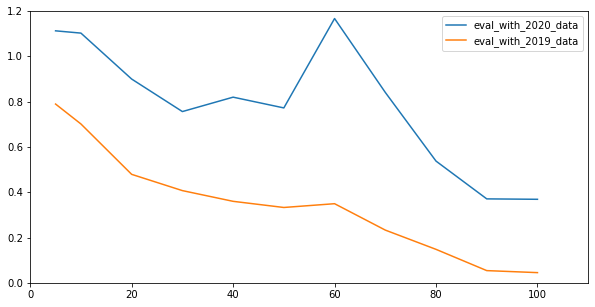

In [139]:
plt.figure(figsize=(10,5))
plt.plot(df1)
plt.legend(['eval_with_2020_data', 'eval_with_2019_data'])
plt.xlim([0, 110])
plt.ylim([0, 1.2])

### Question 4
#### Step1: Use new method to get weights, and evaluate portfolio

In [160]:
num = len(stocks_return_2019) # 250 time slot for 2019

In [33]:
NDX_return_2019 = daily_return_2019['NDX']
stocks_return_2019 = daily_return_2019.drop('NDX',axis=1)

obj = np.array([1]*num+[0]*N*2) #xi=250, wi=100, yi=100

A = np.zeros((num*2+N+2,num+N*2)) 
b = []
direction = np.array(['>']*(num*2+N)+['=']*2)

row = 0
col = 0
# fill first (num*2) rows for A
for i in range(num*2):
    if row % 2 == 0:
        A[row,col] = 1
        A[row,num:(num+N)] = stocks_return_2019.iloc[col].tolist()
        b.append(NDX_return_2019.iloc[col])
        row+=1
    else:
        A[row,col] = 1
        A[row,num:(num+N)] = [i*(-1) for i in stocks_return_2019.iloc[col].tolist()]
        b.append((NDX_return_2019.iloc[col])*(-1))
        row+=1
        col+=1
# fill next N rows for A
for j in range(N):
    A[row,num+j] = -1
    A[row,num+N+j] = M
    b.append(0)
    row+=1
# add a constraint that sum of wi shall be 1
A[row,num:(num+N)] = [1]*N
b.append(1)

# add a constraint that sum of yi shall be m
A[row+1,(num+N):(num+N*2)] = [1]*N
b.append(0)

# for loop for different m
eval_2019 = []
weights = []
for m in m_all:
    b[-1] = m
    
    weightMod = gp.Model()
    weightMod_x = weightMod.addMVar(len(obj),vtype=['C']*(num+N)+['B']*N) 
    weightMod_con = weightMod.addMConstrs(A, weightMod_x, direction, b)
    weightMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    
    #weightMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    weightMod.Params.TimeLimit = time # tell gurobi to shut up!!
    weightMod.optimize()
    
    eval_2019.append(weightMod.objVal)
    weights.append(weightMod_x.x[num:(num+N)])
    #print(weightMod_x.x[num:(num+N)])
    #print(weightMod_x.x[(num+N):(num+N+N)])

#print(eval_2019) #difference in return between portfolio and the index

# Initialize a data frame to record evaluation results
df2 = pd.DataFrame(columns = ['num_of_m', 'evaluation_by_2019'])
df2['num_of_m'] = m
df2['evaluation_by_2019'] = eval_2019
df2.to_csv(r'C:\Users\Elisha\1. Optimization\Project 2\eval_2019_new_method.csv',index = False)

weights = pd.DataFrame(weights)
weights.to_csv(r'C:\Users\Elisha\1. Optimization\Project 2\weights_new_method.csv',index = False)

Changed value of parameter TimeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 602 rows, 450 columns and 50708 nonzeros
Model fingerprint: 0xaf031104
Variable types: 350 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [2e-05, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-05, 5e+00]
Found heuristic solution: objective 1.9064653
Presolve time: 0.04s
Presolved: 602 rows, 450 columns, 50708 nonzeros
Variable types: 350 continuous, 100 integer (100 binary)

Root relaxation: objective 4.491082e-02, 1458 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.04491    0   84    1.90647    0.04491  97.6%    

In [140]:
weights_new = pd.read_csv('weights_new_method.csv')
weights_new

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.250123,0.000000,0.113758,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0,0.102749,0.000000,0.151245,0.000000,0.099202,...,0.000000,0.000000,0.000000,0.105040,0.000000,0.000000,0.000000,0,0.000000,0.000000
2,0.000000,0.032438,0.000000,0.000000,0,0.094003,0.000000,0.111690,0.000000,0.034267,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
3,0.000000,0.040005,0.000000,0.000000,0,0.000000,0.085285,0.100823,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.016258,0.010280,0.000000,0,0.000000,0.000000
4,0.000000,0.027648,0.000000,0.000000,0,0.000000,0.078816,0.097933,0.017360,0.000000,...,0.000000,0.006770,0.015802,0.000000,0.000000,0.008447,0.000000,0,0.000000,0.000000
5,0.008085,0.023610,0.005790,0.004829,0,0.085985,0.000000,0.102688,0.018400,0.000000,...,0.000000,0.003052,0.000000,0.000000,0.007949,0.010624,0.000000,0,0.000000,0.005812
6,0.003411,0.018834,0.004876,0.000000,0,0.086369,0.000000,0.099343,0.014350,0.000000,...,0.000000,0.003991,0.000000,0.000000,0.008708,0.009395,0.003697,0,0.000000,0.005665
7,0.002099,0.018601,0.003663,0.000000,0,0.085265,0.000000,0.097732,0.014392,0.000000,...,0.000000,0.004573,0.008245,0.000000,0.007397,0.009143,0.001221,0,0.000000,0.005836
8,0.003120,0.017842,0.003566,0.001276,0,0.057118,0.028012,0.096184,0.014269,0.000000,...,0.000000,0.004054,0.007081,0.005698,0.007781,0.009247,0.002625,0,0.000000,0.005633
9,0.004223,0.017140,0.004037,0.002450,0,0.056829,0.029717,0.095613,0.013637,0.000000,...,0.000463,0.003833,0.006181,0.006634,0.008832,0.009131,0.002556,0,0.003662,0.005442


### Question 4
#### Step2: Evaluate portfolio using 2020 data

In [142]:
eval_2020 = []

for i in range(len(m_all)):
    stock_idx = []
    weight_val = []
    count = 0
    for idx in range(N):
        if weights_new.to_numpy()[i][idx] > 0:
            stock_idx.append(count)
            weight_val.append(weights_new.to_numpy()[i][idx])
        count=count+1
    
    NDX_return_2020 = daily_return_2020['NDX'].tolist()
    stocks_return_2020 = daily_return_2020.iloc[:,[i + 1 for i in stock_idx]]
    
    A = stocks_return_2020.to_numpy()
    B = weight_val
    portfolio_return_2020 = pd.DataFrame(A*B).T.sum().tolist()
    
    sum = 0
    for j in range(len(portfolio_return_2020)):
        if NDX_return_2020[j] - portfolio_return_2020[j] > 0:
            sum += NDX_return_2020[j] - portfolio_return_2020[j]
        else:
            sum += portfolio_return_2020[j] - NDX_return_2020[j]
    eval_2020.append(sum)

print(eval_2020)  #difference in return between portfolio and the index

[0.7773624843660872, 0.6264951040219303, 0.5306697740724354, 0.47491114813551055, 0.40706120148804376, 0.41147957421833237, 0.3811490041855099, 0.3668044658751281, 0.37060025329098006, 0.36868191551733176, 0.36868191551733176]


In [143]:
# pd.read_csv('eval_new_method.csv') for cross check
df3 = df1.copy()
df3['eval_2020_new_method'] = eval_2020
df3['eval_2019_new_method'] = pd.read_csv('eval_2019_new_method.csv')['evaluation_by_2019'].tolist()
df4 = df3.copy().drop(['evaluation_by_2020','evaluation_by_2019'], axis=1)

df4

,eval_2020_new_method,eval_2019_new_method
num_of_m,,
5,0.777362,0.499259
10,0.626495,0.299563
20,0.530670,0.160711
30,0.474911,0.106094
40,0.407061,0.081338
50,0.411480,0.064503
60,0.381149,0.052260
70,0.366804,0.047588
80,0.370600,0.045227


(0.0, 0.8)

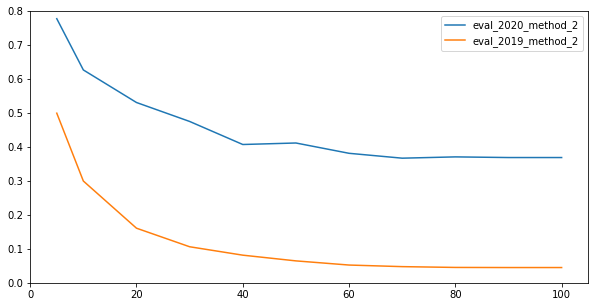

In [144]:
plt.figure(figsize=(10,5))
plt.plot(df4)
plt.legend(['eval_2020_method_2', 'eval_2019_method_2'])
plt.xlim([0, 105])
plt.ylim([0, 0.8])

### Question 4
#### Step3: Compare which method works better on the 2020 data

(0.0, 1.2)

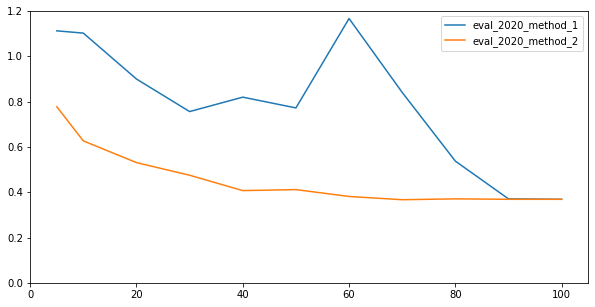

In [132]:
df5 = df3.copy().drop(['evaluation_by_2019','eval_2019_new_method'], axis=1)

plt.figure(figsize=(10,5))
plt.plot(df5)
plt.legend(['eval_2020_method_1', 'eval_2020_method_2'])
plt.xlim([0, 105])
plt.ylim([0, 1.2])

(0.0, 0.8)

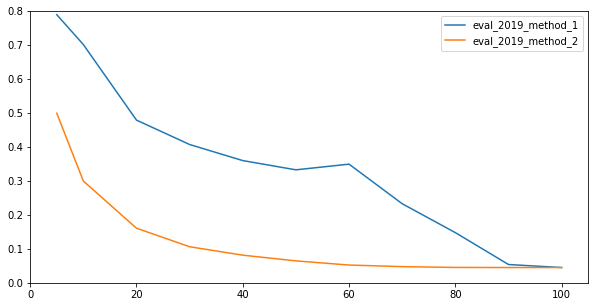

In [133]:
df6 = df3.copy().drop(['evaluation_by_2020','eval_2020_new_method'], axis=1)

plt.figure(figsize=(10,5))
plt.plot(df6)
plt.legend(['eval_2019_method_1', 'eval_2019_method_2'])
plt.xlim([0, 105])
plt.ylim([0, 0.8])

### Recommendations

In [134]:
weights = pd.read_csv('weights_new_method.csv')

In [135]:
chosen_stocks = weights.apply(lambda row: row[row != 0].index, axis=1)[4]
chosen_stocks = list(chosen_stocks)

w = []
for i in weights.loc[4].to_list():
    if i > 0:
        w.append(i)
    
chosen_weights = pd.Series(w,name='Chosen Weights')
chosen_stocks = pd.Series(chosen_stocks,name='Chosen Stocks')
df = pd.concat([chosen_stocks,chosen_weights],axis=1)
df = df.sort_values(by=['Chosen Weights'], ascending=False)
df = df.reset_index()
df = df.drop(['index'], axis=1)
df['Chosen Weights'] = df['Chosen Weights']
df['Chosen Weights'] = df['Chosen Weights']
df['Chosen Weights'] = df['Chosen Weights'].apply('{:.2%}'.format)

df

,Chosen Stocks,Chosen Weights
0,AAPL,10.82%
1,MSFT,9.81%
2,AMZN,9.79%
3,GOOG,7.88%
4,FB,5.45%
5,INTC,3.30%
6,MDLZ,2.84%
7,CSCO,2.78%
8,ADBE,2.76%
9,TXN,2.73%


Text(0.5, 1.0, 'Weight changes of Initial 5 stocks')

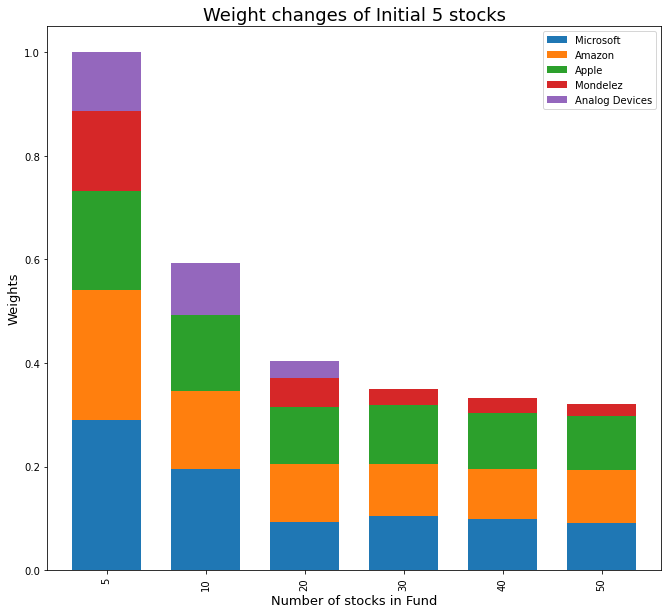

In [136]:
num_stocks = pd.Series(['5','10', '20','30', '40','50'], name='Number of stocks')
amz = pd.Series(weights['AMZN'][0:6],name='Amazon')
df = pd. concat([num_stocks, amz], axis=1) 
ana = pd.Series(weights['ADI'][0:6],name='Analog Devices')
app = pd.Series(weights['AAPL'][0:6],name='Apple')
mic = pd.Series(weights['MSFT'][0:6],name='Microsoft')
mon = pd.Series(weights['MDLZ'][0:6],name='Mondelez')
df = pd.concat([num_stocks,mic,amz,app,mon,ana],axis=1)
df
df = df.set_index('Number of stocks')

df.plot.bar(stacked=True, figsize=(11,10), width = .7)
plt.xlabel('Number of stocks in Fund', fontsize = 13)
plt.ylabel('Weights', fontsize = 13)
plt.title('Weight changes of Initial 5 stocks', fontsize = 18)

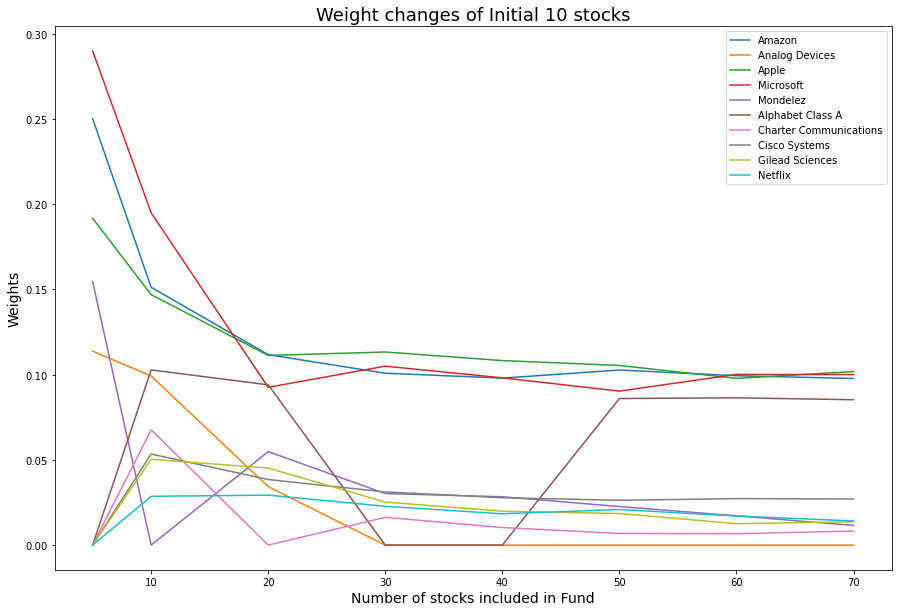

In [137]:
x = [5,10,20,30,40,50,60,70]
plt.figure(figsize=(15,10))
plt.plot(x,weights['AMZN'][0:8], label = 'Amazon')
plt.plot(x,weights['ADI'][0:8], label = 'Analog Devices')
plt.plot(x,weights['AAPL'][0:8], label = 'Apple')
plt.plot(x,weights['MSFT'][0:8], label = 'Microsoft')
plt.plot(x,weights['MDLZ'][0:8], label = 'Mondelez')
plt.plot(x,weights['GOOGL'][0:8], label = 'Alphabet Class A')
plt.plot(x,weights['CHTR'][0:8], label = 'Charter Communications')
plt.plot(x,weights['CSCO'][0:8], label = 'Cisco Systems')
plt.plot(x,weights['GILD'][0:8], label = 'Gilead Sciences')
plt.plot(x,weights['NFLX'][0:8], label = 'Netflix')
plt.xlabel('Number of stocks included in Fund', fontsize = 14)
plt.ylabel('Weights', fontsize = 14)
plt.title('Weight changes of Initial 10 stocks', fontsize = 18)
plt.legend()